In [1]:
!rm -r super-model/
!git clone https://github.com/will-bell/super-model.git

Cloning into 'super-model'...
remote: Enumerating objects: 172, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 172 (delta 103), reused 119 (delta 53), pack-reused 0
Receiving objects: 100% (172/172), 30.18 KiB | 2.32 MiB/s, done.
Resolving deltas: 100% (103/103), done.


In [2]:
# !pip uninstall supermodel

In [3]:
%cd super-model/
!pip install .
%cd ..

/content/super-model
Branch 'installable' set up to track remote branch 'installable' from 'origin'.
Switched to a new branch 'installable'
Processing /content/super-model
  Created wheel for supermodel: filename=supermodel-0.0.0-cp36-none-any.whl size=7551 sha256=3b2edb860341229c38609bb96a62d5d085d681eedc4c68066ad767d45acc3aa2
  Stored in directory: /root/.cache/pip/wheels/30/63/ac/2beefd2a71b2e7ef3089f7328076e5eded19354ccf3320e87d
Successfully built supermodel
  Found existing installation: supermodel 0.0.0
    Uninstalling supermodel-0.0.0:
      Successfully uninstalled supermodel-0.0.0
/content


In [1]:
from typing import Tuple, List, Union

import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pathlib

from supermodel.learn_kinematics import backprop_clfcbf_control
from supermodel.learn_kinematics import learn_kinematics
from supermodel.potential import Potential
from supermodel.sphere_obstacle import SphereObstacle
from supermodel.stochastic_model import ModelEnsemble

In [2]:
class TwoLink:

    link_lengths: Union[Tuple[float, float], None]

    joint_angles: Union[Tuple[float, float], None]

    joint1_position: Union[np.ndarray, None]

    joint2_position: Union[np.ndarray, None]

    end_position: Union[np.ndarray, None]

    jacobian: Union[np.ndarray, None]

    def __init__(self, link_lengths: Tuple[float, float], joint_angles: Tuple[float, float] = (0., 0.)):
        self.link_lengths = link_lengths

        # Initialize these attributes here to be clear (all attributes should be defined in __init__)
        self.joint_angles = self.jacobian = None
        self.end_position = self.joint1_position = self.joint2_position = np.array([[0., 0.]])

        # Assign the missing parameters their values using forward kinematics
        self.update_joints(joint_angles)

    def update_joints(self, joint_angles: Tuple[float, float]):
        self.joint_angles = joint_angles
        self.joint2_position, self.end_position, self.jacobian = self._forward_kinematics(np.array(joint_angles))

    def _forward_kinematics(self, joint_angles: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        if len(joint_angles.shape) < 2:
            joint_angles = joint_angles[np.newaxis]
        theta1, theta2 = joint_angles[:, 0], joint_angles[:, 1]
        l1, l2 = self.link_lengths

        # Calculate the trig values for more concise code
        s1 = np.sin(theta1)[np.newaxis].T
        s12 = np.sin(theta1 + theta2)[np.newaxis].T
        c1 = np.cos(theta1)[np.newaxis].T
        c12 = np.cos(theta1 + theta2)[np.newaxis].T

        joint2_position = self.joint1_position + np.hstack([l1*c1, l1*s1])
        end_position = joint2_position + np.hstack([l2*c12, l2*s12])

        # Construct the Jacobian matrix
        jacobian = np.array([[-l2 * s12 - l1 * s1, -l2 * s12], [l2 * c12 + l1 * c1, l2 * c12]]).squeeze()

        return joint2_position, end_position, jacobian

    def forward_kinematics(self, joint_angles: Tuple[float, float]) -> Tuple[np.ndarray, np.ndarray]:
        _, end_position, jacobian = self._forward_kinematics(np.array(joint_angles))

        return end_position, jacobian

    def forward_kinematics2(self, joint_angles: np.ndarray) -> np.ndarray:
        _, end_position, _ = self._forward_kinematics(joint_angles)

        return end_position

    def plot(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots()
            arm_length = self.link_lengths[0] + self.link_lengths[1]
            ax.set_xlim([-arm_length, arm_length])
            ax.set_ylim([-arm_length, arm_length])
            ax.set_aspect('equal', 'box')

        ax.plot([self.joint1_position[:, 0], self.joint2_position[:, 0]],
                [self.joint1_position[:, 1], self.joint2_position[:, 1]], 'r-')
        
        ax.plot([self.joint2_position[:, 0], self.end_position[:, 0]],
                [self.joint2_position[:, 1], self.end_position[:, 1]], 'r-')
        
        ax.plot(self.joint1_position[:, 0], self.joint1_position[:, 1], 'ko')
        ax.plot(self.joint2_position[:, 0], self.joint2_position[:, 1], 'ko')
        ax.plot(self.end_position[:, 0], self.end_position[:, 1], 'ko')

In [3]:
def torus_grid(delta: float) -> np.ndarray:
    x_range = np.arange(0., 2 * np.pi, delta)
    y_range = np.arange(0., 2 * np.pi, delta)
    xx, yy = np.meshgrid(x_range, y_range)
    configurations = np.vstack([xx.ravel(), yy.ravel()]).T
    configurations = (configurations + np.random.uniform(-delta / 4., delta / 4., configurations.shape)) % (2 * np.pi)

    return configurations

In [4]:
def twolink_forward_kinematics(joint_angles: np.ndarray) -> np.ndarray:
    theta1, theta2 = joint_angles[:, 0], joint_angles[:, 1]
    l1, l2 = 1, 1

    # Calculate the trig values for more concise code
    s1 = np.sin(theta1)
    s12 = np.sin(theta1 + theta2)
    c1 = np.cos(theta1)
    c12 = np.cos(theta1 + theta2)

    joint_position = np.vstack([l1*c1, l1*s1]).T
    end_position = joint_position + np.vstack([l2 * c12, l2 * s12]).T

    return end_position

In [5]:
model_dir = pathlib.Path('./models')
model_path = model_dir / 'twolink_test'

torus_configurations = torus_grid(.02)
model_ensemble = ModelEnsemble(100, 2, 2, [512, 512])
model_ensemble, loss_history = learn_kinematics(model_ensemble, twolink_forward_kinematics, torus_configurations,
                                                lr=1e-3, train_batch_size=200, valid_batch_size=100, n_epochs=5, 
                                                log_period=20, l2_reg=.0001)

Using device: cuda
Tesla V100-SXM2-16GB
Memory Usage:
Allocated: 101.2 MB
Cached:    102.0 MB
Epoch = 1, Total Updates = 0, Mean loss = 2.3312675952911377
Epoch = 1, Total Updates = 20, Mean loss = 0.6673605442047119
Epoch = 1, Total Updates = 40, Mean loss = 0.5046539902687073
Epoch = 1, Total Updates = 60, Mean loss = 0.4087521731853485
Epoch = 1, Total Updates = 80, Mean loss = 0.34376174211502075
Epoch = 1, Total Updates = 100, Mean loss = 0.2980579435825348
Epoch = 1, Total Updates = 120, Mean loss = 0.25981149077415466
Epoch = 1, Total Updates = 140, Mean loss = 0.24201738834381104
Epoch = 1, Total Updates = 160, Mean loss = 0.20165683329105377
Epoch = 1, Total Updates = 180, Mean loss = 0.1760735809803009
Epoch = 1, Total Updates = 200, Mean loss = 0.1606559306383133
Epoch = 1, Total Updates = 220, Mean loss = 0.1538277417421341
Epoch = 1, Total Updates = 240, Mean loss = 0.14234618842601776
Epoch = 1, Total Updates = 260, Mean loss = 0.11898252367973328
Epoch = 1, Total Updates

In [13]:
!rm -r models/

In [8]:
!rm twolink_test.zip

In [7]:
model_ensemble.save(model_path)

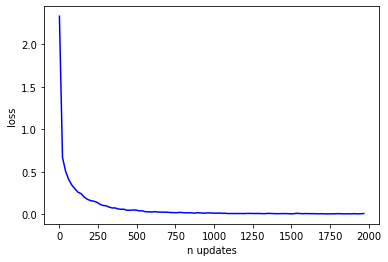

In [6]:
plt.plot(loss_history[:, 0], loss_history[:, 1], '-b')
plt.xlabel('n updates')
plt.ylabel('loss')
plt.show()

In [9]:
!zip -r /content/twolink_test.zip /content/models/twolink_test

  adding: content/models/twolink_test/ (stored 0%)
  adding: content/models/twolink_test/model-13.pt (deflated 6%)
  adding: content/models/twolink_test/model-68.pt (deflated 6%)
  adding: content/models/twolink_test/model-64.pt (deflated 6%)
  adding: content/models/twolink_test/model-94.pt (deflated 6%)
  adding: content/models/twolink_test/model-91.pt (deflated 6%)
  adding: content/models/twolink_test/model-62.pt (deflated 6%)
  adding: content/models/twolink_test/model-72.pt (deflated 6%)
  adding: content/models/twolink_test/model-22.pt (deflated 6%)
  adding: content/models/twolink_test/model-60.pt (deflated 6%)
  adding: content/models/twolink_test/model-90.pt (deflated 6%)
  adding: content/models/twolink_test/model-31.pt (deflated 6%)
  adding: content/models/twolink_test/model-95.pt (deflated 6%)
  adding: content/models/twolink_test/model-43.pt (deflated 6%)
  adding: content/models/twolink_test/model-47.pt (deflated 6%)
  adding: content/models/twolink_test/model-85.pt (de

In [10]:
from google.colab import files
files.download("/content/twolink_test.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
import pandas

In [13]:
pandas.DataFrame(loss_history).to_csv('twolink_loss_history.csv')